In [10]:
###conda activate test_yolov5
%matplotlib inline
import matplotlib.pyplot as plt

import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'  # or any {'0', '1', '2'} to control the verbosity
import cv2
import numpy as np
import time
from ultralytics import YOLO
from collections import deque

from libs.bbox3d_utils import *
from libs.Plotting import *
from train import * 

from tensorflow.keras.applications import *
from tensorflow.keras.models import *
from tensorflow.keras.optimizers import *
from tensorflow.keras.layers import *
from tensorflow.keras.callbacks import TensorBoard, EarlyStopping, ModelCheckpoint
from tensorflow.keras.losses import Loss

def display_image(img):
    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    plt.imshow(img_rgb)
    plt.show()

select_model = 'mobilenetv2'

# Load the 3D model
bbox3d_model = load_model(f'/home/mosminin/veh3d/YOLOv8-3D/mobilenetv2/mobilenetv2_weights.h5')
bin_size = 6
input_shape = (224, 224, 3)
trained_classes = ['Car', 'Cyclist', 'Pedestrian']
# print(bbox3d_model.summary())
print('loading file ...'+select_model+'_weights.h5...!')
P2 = np.array([[718.856, 0.0, 607.1928, 45.38225], [0.0, 718.856, 185.2157, -0.1130887], [0.0, 0.0, 1.0, 0.003779761]])
dims_avg = {'Car': np.array([1.52131309, 1.64441358, 3.85728004]),
'Van': np.array([2.18560847, 1.91077601, 5.08042328]),
'Truck': np.array([3.07044968,  2.62877944, 11.17126338]),
'Pedestrian': np.array([1.75562272, 0.67027992, 0.87397566]),
'Person_sitting': np.array([1.28627907, 0.53976744, 0.96906977]),
'Cyclist': np.array([1.73456498, 0.58174006, 1.77485499]),
'Tram': np.array([3.56020305,  2.40172589, 18.60659898])}
# print(dims_avg)

# Load a 2D model
bbox2d_model = YOLO('yolov8n-seg.pt')  # load an official model
# set model parameters
bbox2d_model.overrides['conf'] = 0.9  # NMS confidence threshold
bbox2d_model.overrides['iou'] = 0.45  # NMS IoU threshold
bbox2d_model.overrides['agnostic_nms'] = False  # NMS class-agnostic
bbox2d_model.overrides['max_det'] = 1000  # maximum number of detections per image
bbox2d_model.overrides['classes'] = 2 ## define classes
yolo_classes = ['Pedestrian', 'Cyclist', 'Car', 'motorcycle', 'airplane', 'Van', 'train', 'Truck', 'boat']

# Load the video
video = cv2.VideoCapture('/mnt/m/dev/veh3d/vehicle_3D/YOLOv8-3D/source_video.mp4')
# Переместить позицию каретки на 50-й кадр
video.set(cv2.CAP_PROP_POS_FRAMES, 50)

### svae results
# Get video information (frame width, height, frames per second)
frame_width = int(video.get(cv2.CAP_PROP_FRAME_WIDTH))
frame_height = int(video.get(cv2.CAP_PROP_FRAME_HEIGHT))
fps = int(video.get(cv2.CAP_PROP_FPS))
# Define the codec and create a VideoWriter object
fourcc = cv2.VideoWriter_fourcc(*'mp4v')  # Change the codec if needed (e.g., 'XVID')
out = cv2.VideoWriter('' + select_model+'_output_video.mp4', fourcc, 5, (frame_width, frame_height))

tracking_trajectories = {}

def process2D(image, track = False, device = 0):
    bboxes = []
    if track is True:
        results = bbox2d_model.track(image, verbose=False, device=device, persist=True)

        for id_ in list(tracking_trajectories.keys()):
            if id_ not in [int(bbox.id) for predictions in results if predictions is not None for bbox in predictions.boxes if bbox.id is not None]:
                del tracking_trajectories[id_]

        for predictions in results:
            if predictions is None:
                continue

            if predictions.boxes is None or predictions.masks is None or predictions.boxes.id is None:
                continue

            for bbox, masks in zip(predictions.boxes, predictions.masks):
                ## object detections
                for scores, classes, bbox_coords, id_ in zip(bbox.conf, bbox.cls, bbox.xyxy, bbox.id):
                    xmin    = bbox_coords[0]
                    ymin    = bbox_coords[1]
                    xmax    = bbox_coords[2]
                    ymax    = bbox_coords[3]
                    cv2.rectangle(image, (int(xmin), int(ymin)), (int(xmax), int(ymax)), (0,0,225), 2)
                    bboxes.append([bbox_coords, scores, classes, id_])

                    label = (' '+f'ID: {int(id_)}'+' '+str(predictions.names[int(classes)]) + ' ' + str(round(float(scores) * 100, 1)) + '%')
                    text_size = cv2.getTextSize(label, cv2.FONT_HERSHEY_SIMPLEX, 2, 1)
                    dim, baseline = text_size[0], text_size[1]
                    cv2.rectangle(image, (int(xmin), int(ymin)), ((int(xmin) + dim[0] //3) - 20, int(ymin) - dim[1] + baseline), (30,30,30), cv2.FILLED)
                    cv2.putText(image,label,(int(xmin), int(ymin) - 7), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255,255,255), 1)

                    centroid_x = (xmin + xmax) / 2
                    centroid_y = (ymin + ymax) / 2

                    # Append centroid to tracking_points
                    if id_ is not None and int(id_) not in tracking_trajectories:
                        tracking_trajectories[int(id_)] = deque(maxlen=5)
                    if id_ is not None:
                        tracking_trajectories[int(id_)].append((centroid_x, centroid_y))

                # Draw trajectories
                for id_, trajectory in tracking_trajectories.items():
                    for i in range(1, len(trajectory)):
                        thickness = int(2 * (i / len(trajectory)) + 1)
                        cv2.line(image, (int(trajectory[i-1][0]), int(trajectory[i-1][1])), 
                                 (int(trajectory[i][0]), int(trajectory[i][1])), (255, 255, 255), thickness)

                ## object segmentations
                for mask in masks.xy:
                    polygon = mask
                    cv2.polylines(image, [np.int32(polygon)], True, (255, 0, 0), thickness=2)


    if not track:
        results = bbox2d_model.predict(image, verbose=False, device=device)  # predict on an image
        for predictions in results:
            if predictions is None:
                continue  # Skip this image if YOLO fails to detect any objects
            if predictions.boxes is None or predictions.masks is None:
                continue  # Skip this image if there are no boxes or masks

            for bbox, masks in zip(predictions.boxes, predictions.masks): 
                ## object detections
                for scores, classes, bbox_coords in zip(bbox.conf, bbox.cls, bbox.xyxy):
                    xmin    = bbox_coords[0]
                    ymin    = bbox_coords[1]
                    xmax    = bbox_coords[2]
                    ymax    = bbox_coords[3]
                    cv2.rectangle(image, (int(xmin), int(ymin)), (int(xmax), int(ymax)), (0,0,225), 2)
                    bboxes.append([bbox_coords, scores, classes])

                    label = (' '+str(predictions.names[int(classes)]) + ' ' + str(round(float(scores) * 100, 1)) + '%')
                    text_size = cv2.getTextSize(label, cv2.FONT_HERSHEY_SIMPLEX, 2, 1)
                    dim, baseline = text_size[0], text_size[1]
                    cv2.rectangle(image, (int(xmin), int(ymin)), ((int(xmin) + dim[0] //3) - 20, int(ymin) - dim[1] + baseline), (30,30,30), cv2.FILLED)
                    cv2.putText(image,label,(int(xmin), int(ymin) - 7), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255,255,255), 1)

                ## object segmentations
                for mask in masks.xy:
                    polygon = mask
                    cv2.polylines(image, [np.int32(polygon)], True, (255, 0, 0), thickness=2)

    return image, bboxes

def process3D(img, bboxes2d):
    DIMS = []
    bboxes = []
    for item in bboxes2d:
        bbox_coords, scores, classes, *id_ = item if len(item) == 4 else (*item, None)
        padding = 0  # Set the padding value
        xmin = max(0, bbox_coords[0] - padding)
        ymin = max(0, bbox_coords[1] - padding)
        xmax = min(frame.shape[1], bbox_coords[2] + padding)
        ymax = min(frame.shape[0], bbox_coords[3] + padding)
        objID = id_


        crop = img[int(ymin) : int(ymax), int(xmin) : int(xmax)]
        patch = tf.convert_to_tensor(crop, dtype=tf.float32)
        patch /= 255.0  # Normalize to [0,1]
        patch = tf.image.resize(patch, (224, 224))  # Resize to 224x224
        patch = tf.expand_dims(patch, axis=0)  # Equivalent to reshape((1, *crop.shape))
        prediction = bbox3d_model.predict(patch, verbose = 0)

        dim = prediction[0][0]
        bin_anchor = prediction[1][0]
        bin_confidence = prediction[2][0]

        ###refinement dimension
        try:
            dim += dims_avg[str(yolo_classes[int(classes.cpu().numpy())])] + dim
            DIMS.append(dim)
        except:
            dim = DIMS[-1]

        bbox_ = [int(xmin), int(ymin), int(xmax), int(ymax)]
        theta_ray = calc_theta_ray(frame, bbox_, P2)
        # update with predicted alpha, [-pi, pi]
        alpha = recover_angle(bin_anchor, bin_confidence, bin_size)
        alpha = alpha - theta_ray

        # calculate the location   # plot 3d bbox
        location, x = calc_location(dimension=dim, proj_matrix=P2, box_2d=bbox_, alpha=alpha, theta_ray=theta_ray)
        bboxes.append([bbox_, dim, alpha, theta_ray, bin_anchor, bin_confidence, classes, location, objID])

    return bboxes

frameId = 0
start_time = time.time()
fps = str()
BEV_plot = True
TracK = False

loading file ...mobilenetv2_weights.h5...!


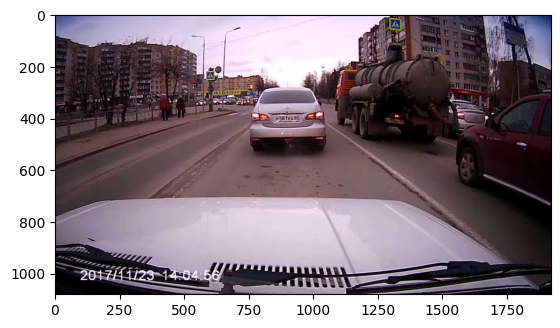

In [11]:
_, test_frame = video.read()
display_image(test_frame)

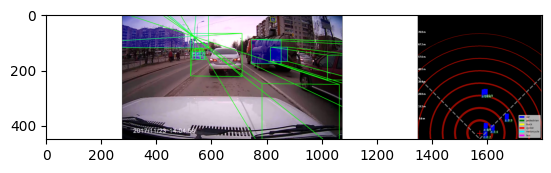

KeyboardInterrupt: 

In [14]:
frameId+=1
_, frame = video.read()

img = frame.copy() 
img2 = frame.copy() 
img3 = frame.copy()
plot3dbev = Plot3DBoxBev(P2)  

## process 2D and 3D boxes
start_2d = time.time()
img2D, bboxes2d = process2D(img2, track=TracK)
end_2d = time.time() - start_2d
if len(bboxes2d) > 0:
    start_3d = time.time()
    bboxes3D = process3D(img, bboxes2d)
    end_3d = time.time() - start_3d
    if len(bboxes3D) > 0:
        for bbox_, dim, alpha, theta_ray, orient, conf,  classes, location, objID in bboxes3D:
            plot3d(img3, P2, bbox_, dim, alpha, theta_ray)

            if BEV_plot:
                # initialize object container
                obj = KITTIObject()
                obj.name = str(yolo_classes[int(classes.cpu().numpy())])
                obj.truncation = float(0.00)
                obj.occlusion = int(-1)
                obj.xmin, obj.ymin, obj.xmax, obj.ymax = int(bbox_[0]), int(bbox_[1]), int(bbox_[2]), int(bbox_[3])

                obj.alpha = recover_angle(orient, conf, bin_size)
                obj.h, obj.w, obj.l = dim[0], dim[1], dim[2]
                obj.rot_global, rot_local = compute_orientaion(P2, obj)
                obj.tx, obj.ty, obj.tz = translation_constraints(P2, obj, rot_local)

                # plot 3d BEV bbox
                rot_y = alpha + theta_ray
                plot3dbev.plot(img=img3, class_object=obj.name.lower(), 
                    bbox=[obj.xmin, obj.ymin, obj.xmax, obj.ymax],
                    dim=[obj.h, obj.w, obj.l], loc=[obj.tx, obj.ty, obj.tz], rot_y=rot_y, objId=[objID] if not isinstance(objID, list) else objID)

        if BEV_plot:
            plot3dbev.plot(img=img3)
            img3 = plot3dbev.show_result()


# Calculate the current time in seconds
current_time = video.get(cv2.CAP_PROP_POS_MSEC) / 1000.0
# if frameId % 20 == 0:  # Calculate FPS every 10 frames
#     end_time = time.time()
#     elapsed_time = end_time - start_time
#     fps_current = frameId / elapsed_time
#     fps =  f'FPS: {fps_current:.2f}'
#     print(f'Frame: {frameId}, FPS: {fps_current:.2f}')
end_time = time.time()
elapsed_time = end_time - start_time
fps_current = frameId / elapsed_time
fps =  f'FPS: {fps_current:.2f}'
cv2.putText(img3, select_model+' '+fps, (10, 30), cv2.FONT_HERSHEY_SIMPLEX, 0.7, (0, 0, 255), 1, cv2.LINE_AA)

print(f'ID{frameId}:{end_2d=:.3f} {end_3d=:.3f} {fps=}\r', end='')

# Display the frame
cv2.imshow("2D", img2)
cv2.imshow("3D", img3)

# if img2.shape[0] != img3.shape[0]:
#     height = min(img2.shape[0], img3.shape[0])
#     img2 = cv2.resize(img2, (img2.shape[1], height)) # измените размер img1
#     img3 = cv2.resize(img3, (img3.shape[1], height)) # измените размер img2

# img_comb = cv2.hconcat([img2, img3])

# cv2.imwrite(f'./{select_model}_output/{frameId}_{select_model}_frame.png', img_comb)

# out.write(img3)

In [9]:
cv2.destroyAllWindows()

In [ ]:
out.release()
video.release()
cv2.destroyAllWindows()